In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import anndata as ad
from pathlib import Path
import numpy as np
import pandas as pd

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/optuna/study/_optimize.py:29: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module


In [2]:
split = 3

In [3]:
adata_pred_ood = sc.read(f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/combosciplex/adata_ood_with_predictions_{split}.h5ad")


In [4]:
adata_pred_ood.X = adata_pred_ood.layers["X_recon_pred"]


In [5]:
adata_train_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_train_{split}.h5ad"
adata_test_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_test_{split}.h5ad"
adata_ood_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_ood_{split}.h5ad"

In [6]:
adata_train = sc.read(adata_train_path)
adata_test = sc.read(adata_test_path)
adata_ood = sc.read(adata_ood_path)

In [7]:
adata_pred_ood = adata_pred_ood[adata_pred_ood.obs["condition"]!="control"]

In [8]:
adata_pred_ood.var_names = adata_ood.var_names

In [9]:
adata_ood.obs["condition"].unique()

['control+Dacinostat', 'Panobinostat+Sorafenib', 'Panobinostat+SRT1720', 'Panobinostat+Crizotinib', 'control+Alvespimycin', 'Panobinostat+Curcumin', 'SRT2104+Alvespimycin', 'control']
Categories (8, object): ['Panobinostat+Crizotinib', 'Panobinostat+Curcumin', 'Panobinostat+SRT1720', 'Panobinostat+Sorafenib', 'SRT2104+Alvespimycin', 'control', 'control+Alvespimycin', 'control+Dacinostat']

In [44]:
genes = adata_ood.var_names

control = adata_ood[adata_ood.obs['condition'] == 'control']
mean_control = np.mean(np.asarray(control.X.toarray()), axis=0)  

all_dfs = []

for cond in adata_ood.obs["condition"].unique():
    if cond=="control":
        continue
    treated = adata_ood[adata_ood.obs['condition'] == cond]
    treated_pred = adata_pred_ood[adata_pred_ood.obs['condition'] == cond]
    mean_treated = np.mean(np.asarray(treated.X.toarray()), axis=0)  
    mean_treated_pred = np.mean(np.asarray(treated_pred.X.toarray()), axis=0)  
    log_fold_change = np.log2(mean_treated + 1) - np.log2(mean_control + 1)
    log_fold_change_pred = np.log2(mean_treated_pred + 1) - np.log2(mean_control + 1) 
    logfc_df = pd.DataFrame({
        'gene': genes,
        'log_fold_change': log_fold_change,
        'log_fold_change_pred': log_fold_change_pred
    })
    logfc_df["is_deg"] = logfc_df.apply(lambda x: x["gene"] in adata_train.uns["rank_genes_groups_cov_all"][cond], axis=1)
    logfc_df["condition"] = cond
    all_dfs.append(logfc_df)

df_logfoldchanges = pd.concat(all_dfs)

In [45]:
df_logfoldchanges.to_csv("/lustre/groups/ml01/workspace/ot_perturbation/analysis/combosciplex/logfoldchanges_split_3.csv")

In [46]:
d_lfc = {}
for i, df in enumerate(all_dfs):
    cond = adata_ood.obs["condition"].unique()[i]
    d_lfc[cond] = df

In [47]:
upregulated_genes = []
downregulated_genes = []
for cond, df in d_lfc.items():
    df_up = df.sort_values("log_fold_change").iloc[-5:]
    upregulated_genes.append(df_up)
    df_down = df.sort_values("log_fold_change").iloc[0:5]
    downregulated_genes.append(df_down)

In [48]:
df_up = pd.concat(upregulated_genes)
df_down = pd.concat(downregulated_genes)

In [49]:
df_up["gene"].value_counts()

gene
CEACAM22P     4
TFPI2         4
COL26A1       4
INSIG1        3
AC010197.1    3
AC008014.1    2
DHRS2         2
PTPRJ         2
HSPA1A        2
PDGFD         2
ATP1B3        2
MALAT1-1      1
ANXA1         1
IGFL2-AS1     1
CYP4F3        1
HSPH1         1
Name: count, dtype: int64

In [50]:
df_down["gene"].value_counts()

gene
AKR1B10    5
ABCC2      4
ABCC3      4
TOP2A      2
ALDH3A1    2
KRT7       2
CA12       2
KYNU       2
MKI67      2
KRT81      2
THSD4      2
SLC12A2    2
PDE4B      1
CENPF      1
TUBA1B     1
AGR2       1
Name: count, dtype: int64

In [51]:
up_genes = df_up["gene"].unique()
down_genes = df_down["gene"].unique()

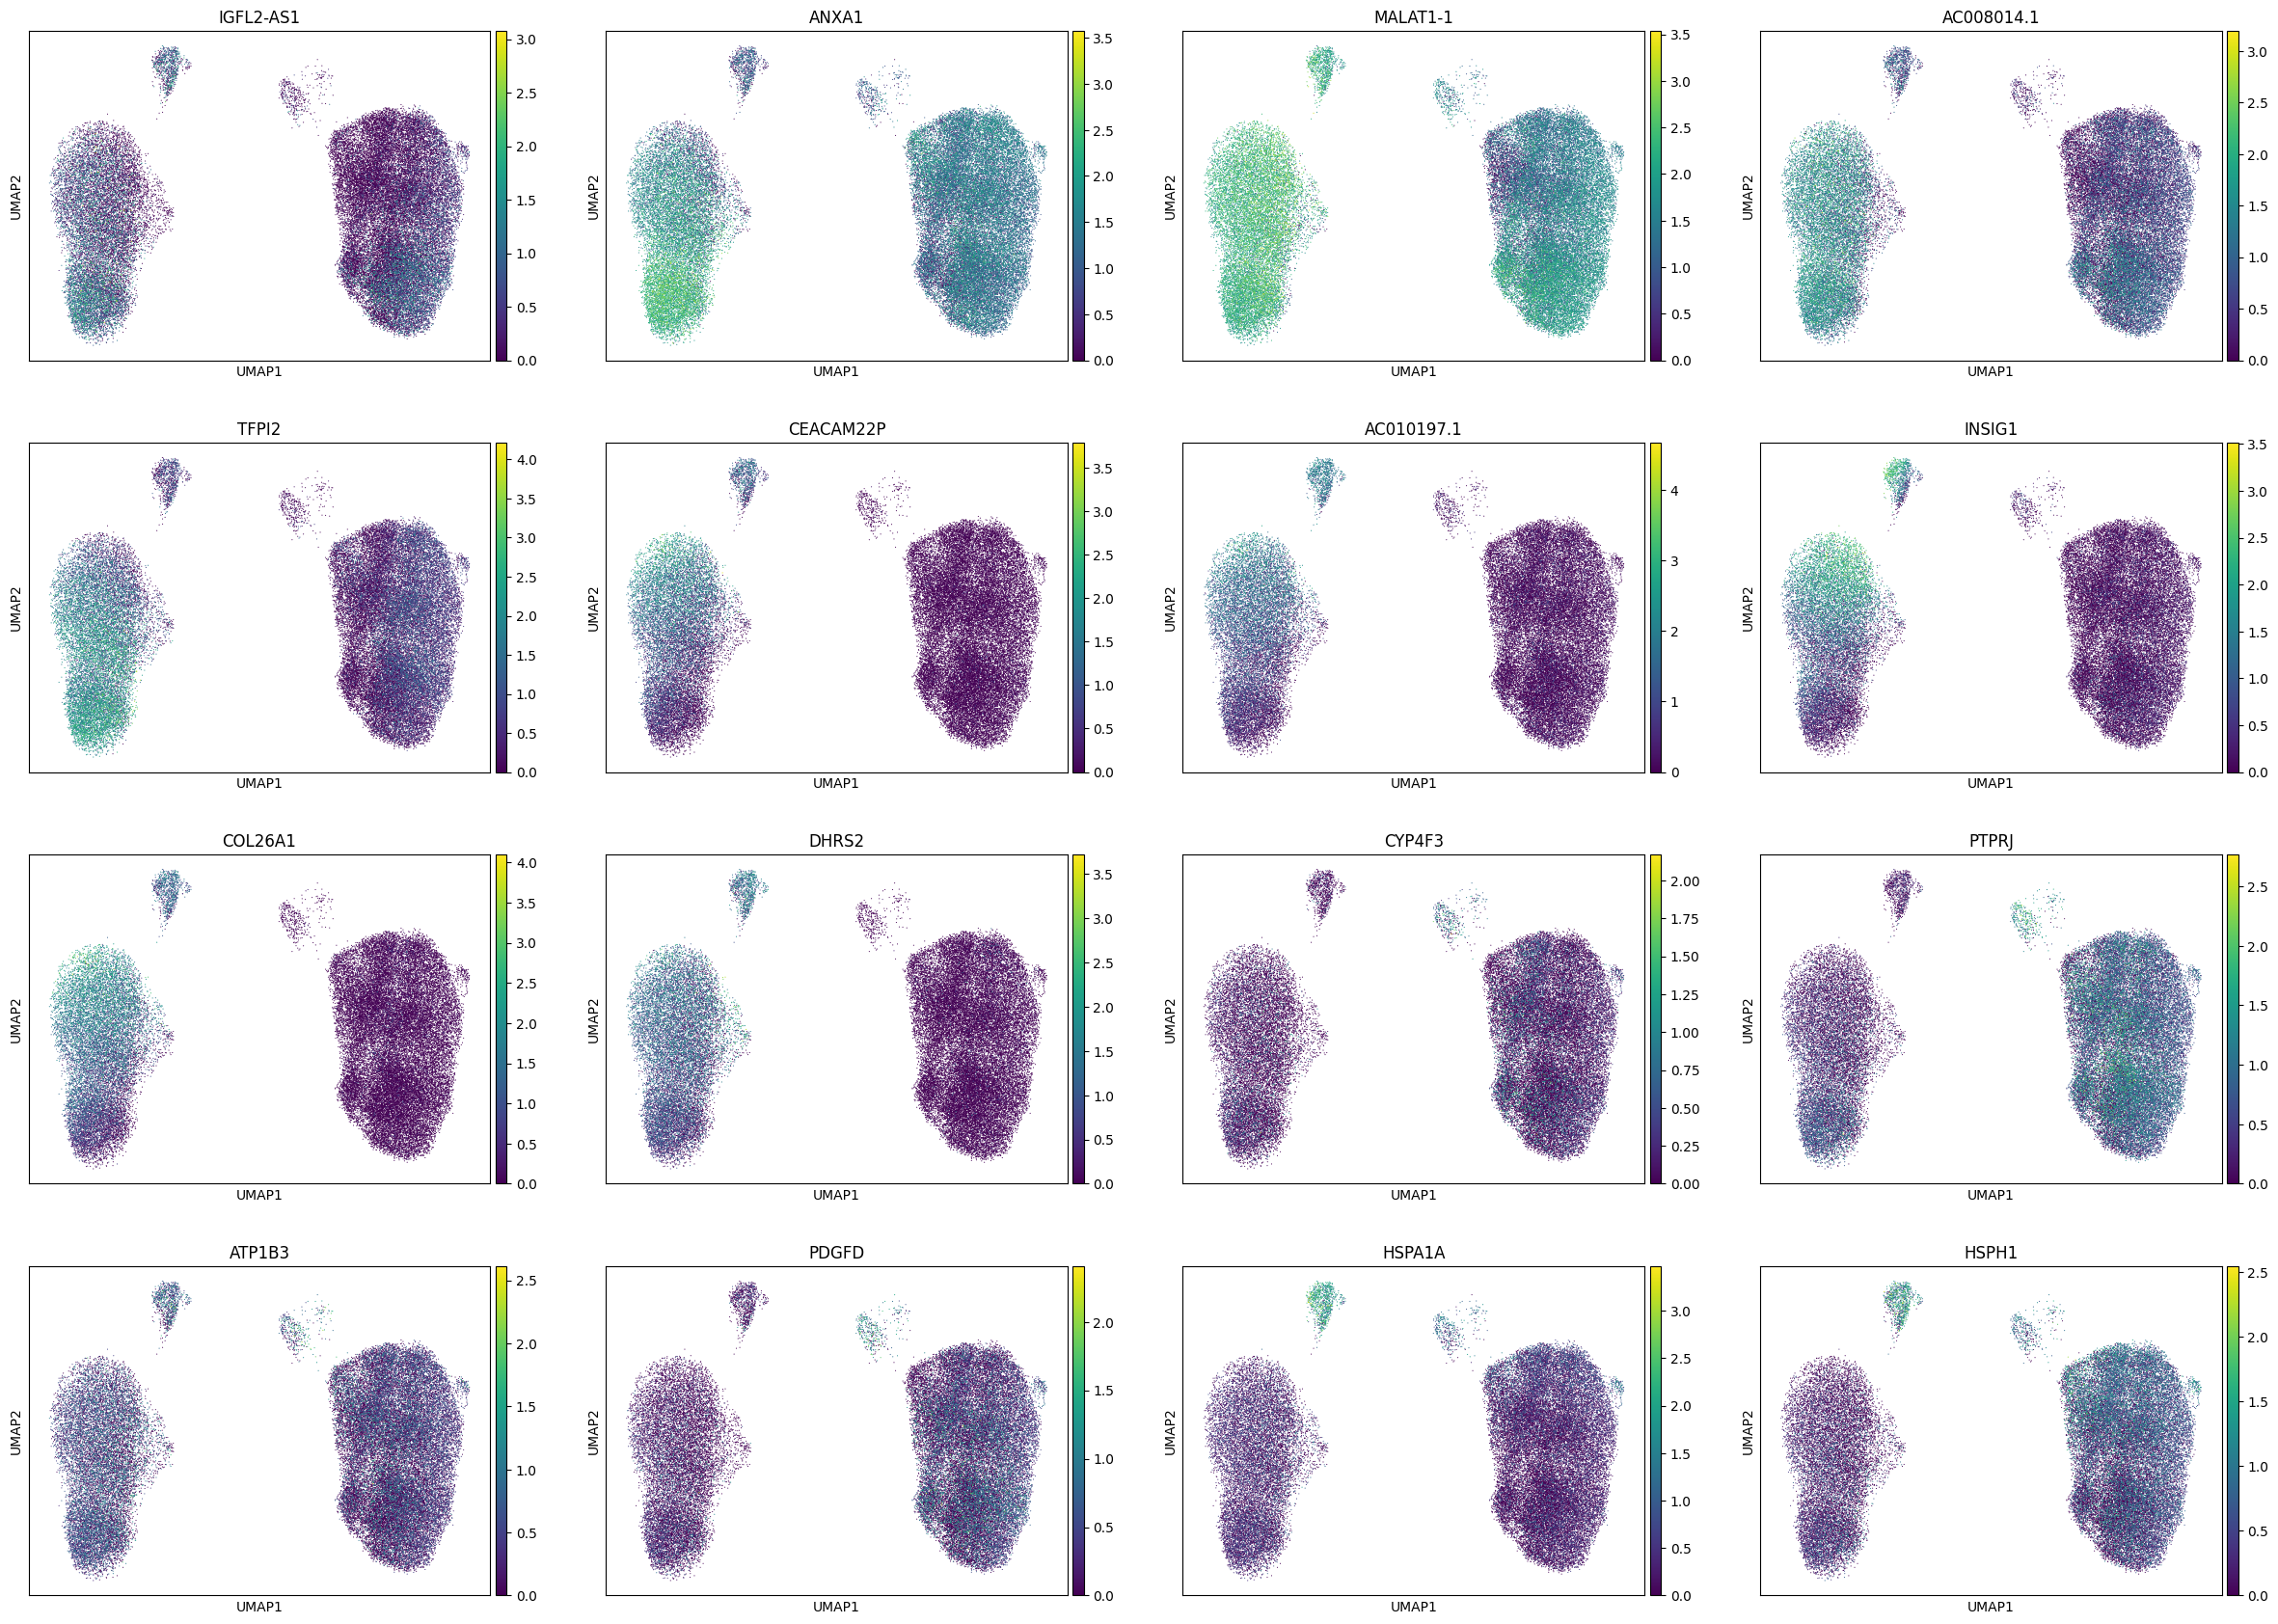

In [52]:
sc.pl.umap(adata_train, color=up_genes) # TODO replace with full adata

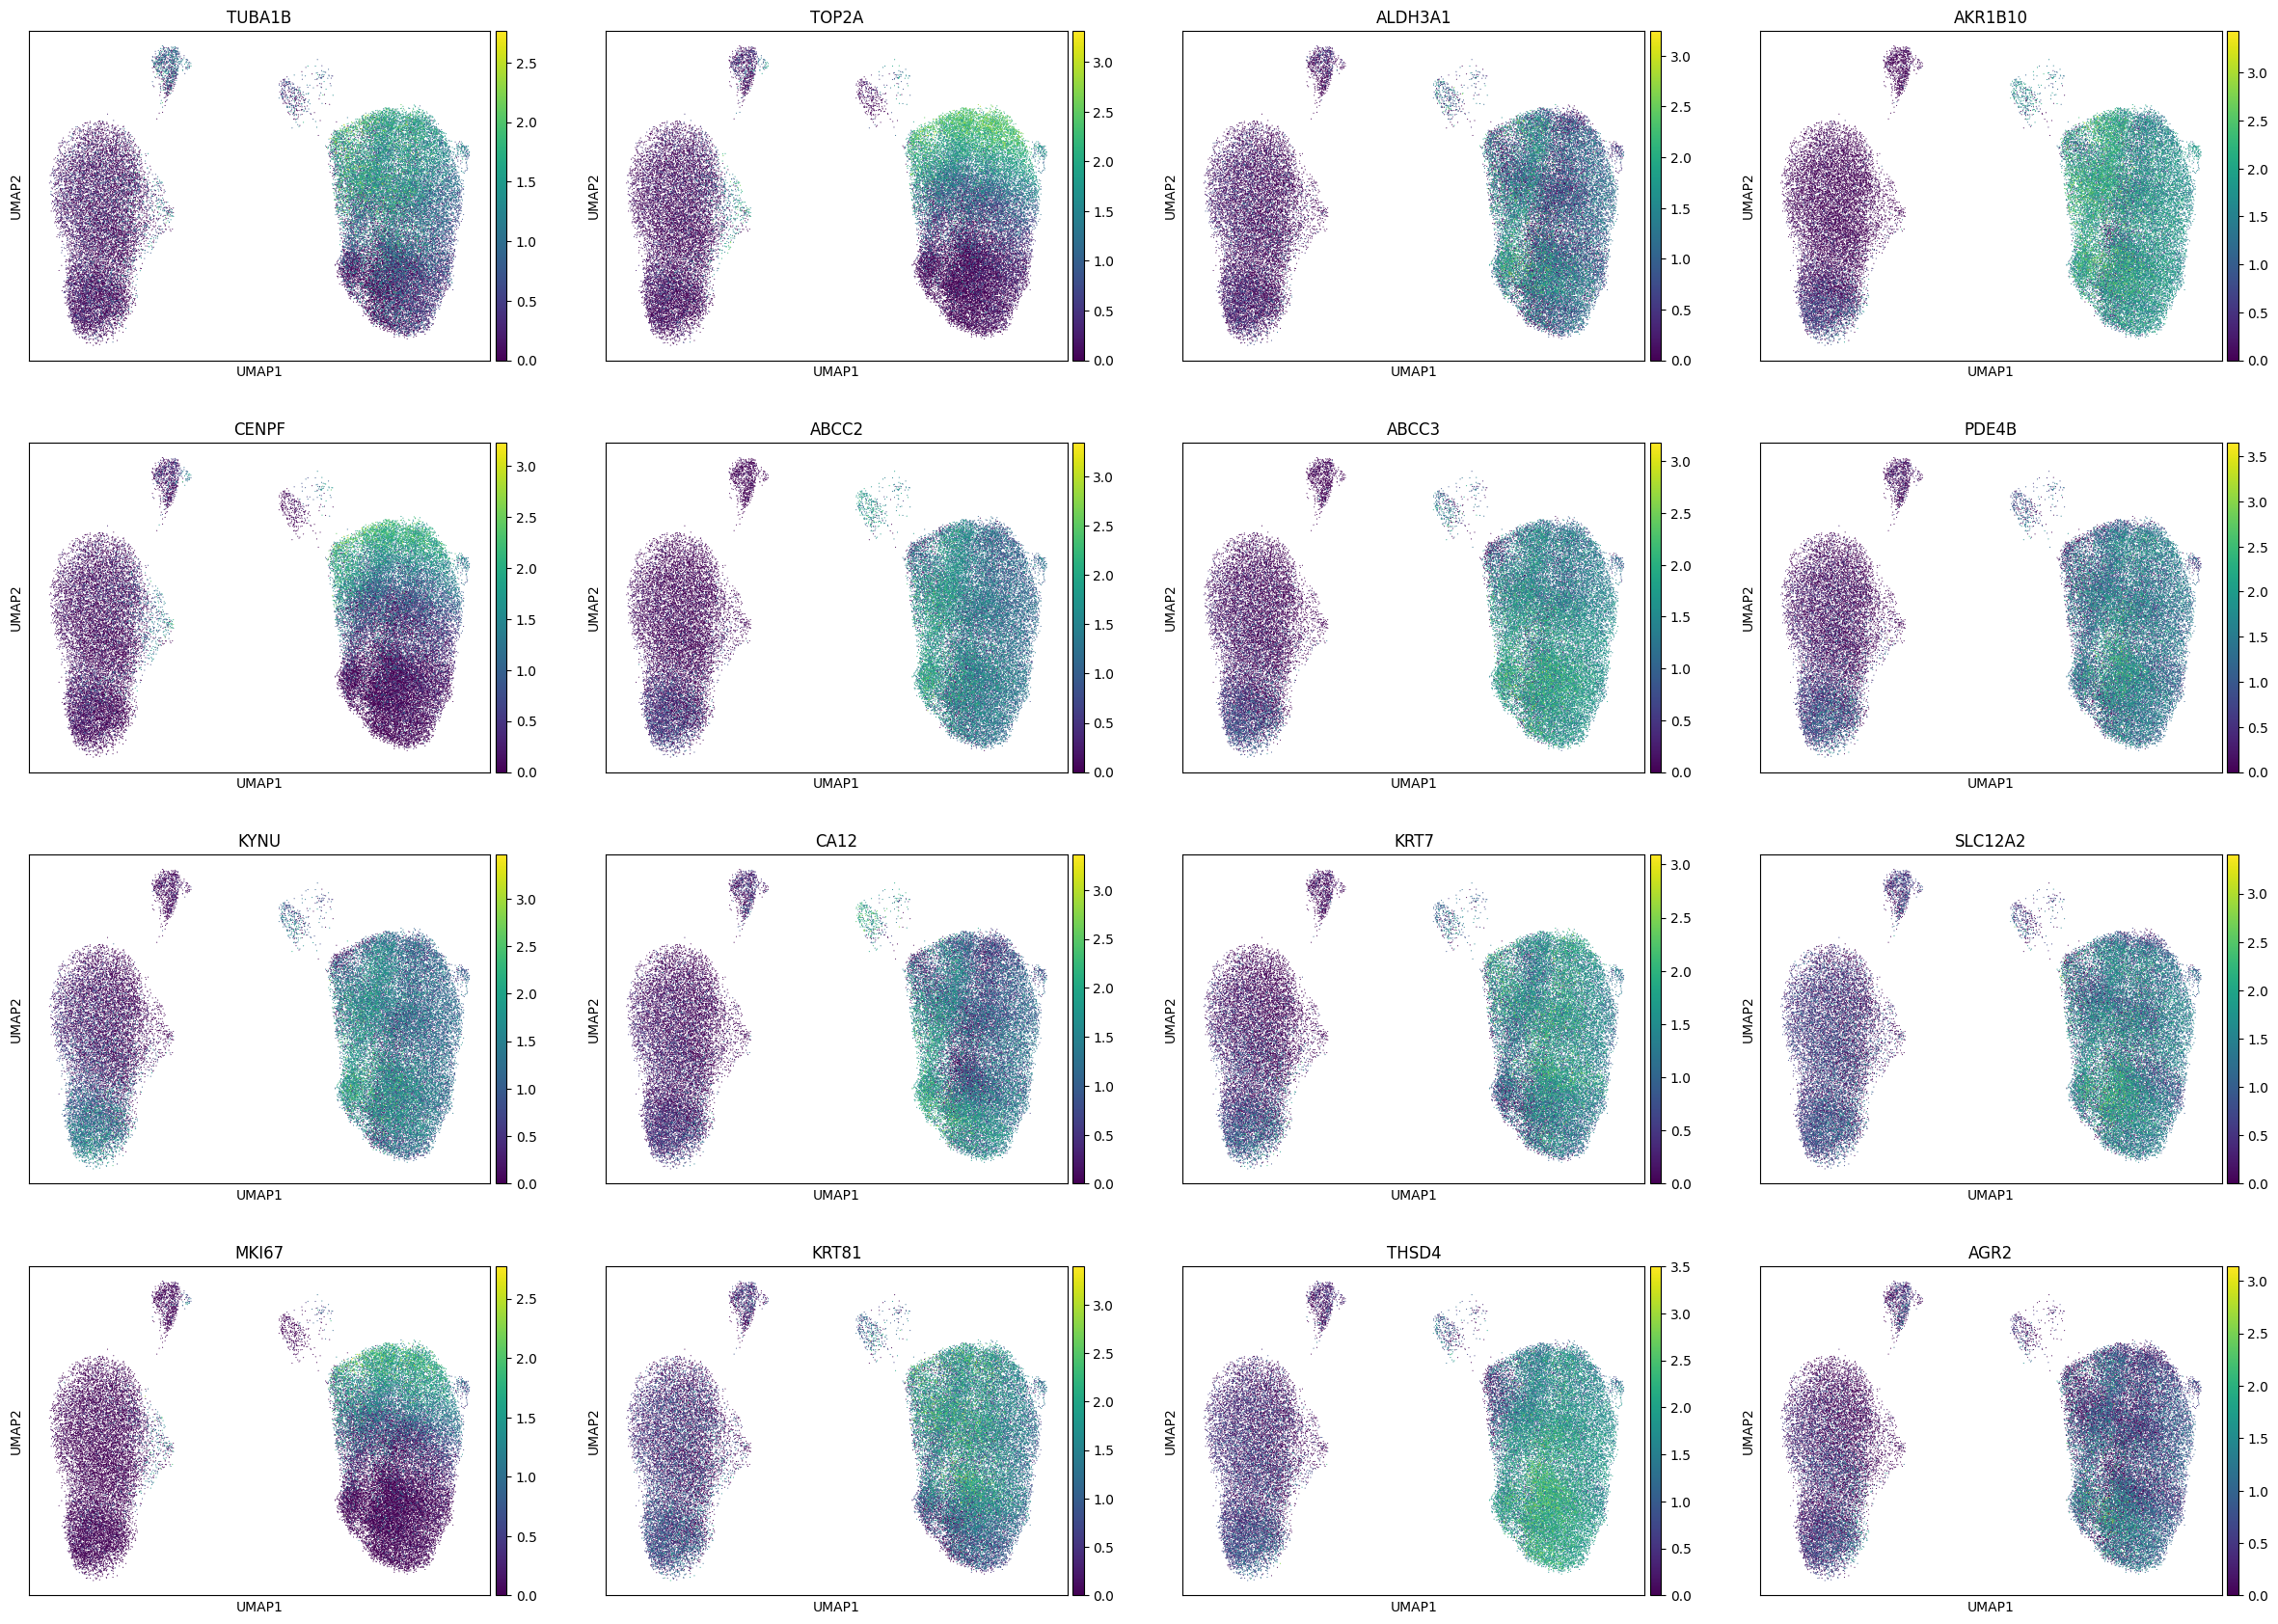

In [53]:
sc.pl.umap(adata_train, color=down_genes) # TODO replace with full adata

In [54]:
df_up.to_csv("/lustre/groups/ml01/workspace/ot_perturbation/analysis/combosciplex/upregulated_genes_split_3.csv")
df_down.to_csv("/lustre/groups/ml01/workspace/ot_perturbation/analysis/combosciplex/downregulated_genes_split_3.csv")

'control+Dacinostat':

TFPI2: https://www.sciencedirect.com/science/article/pii/S0169500211004715 (down)
MALAT1-1: https://ncbi.nlm.nih.gov/gene/72289 (down)
TUBA1B: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10369087/ (up)

'Panobinostat+Sorafenib':

COL26A1 (down)
TFPI2: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3722576/ (down)
AKR1B10: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6209774/ (up)

'Panobinostat+SRT1720':

COL26A1 (down)
TFPI2 (down)

In [18]:
all_dfs[2].sort_values("log_fold_change")

gene  log_fold_change  log_fold_change_pred  is_deg  \
621      COL26A1        -1.104443             -1.143952    True   
192        TFPI2        -1.096598             -1.089249    True   
1245   CEACAM22P        -0.887883             -0.906651    True   
1658  AC008014.1        -0.879369             -0.820586    True   
163        DHRS2        -0.841910             -0.929085    True   
...          ...              ...                   ...     ...   
354        TOP2A         0.807543              0.964105    True   
98          CA12         0.817096              0.855958    True   
214        ABCC3         0.915178              1.032965    True   
37         ABCC2         1.002205              1.175165    True   
988      AKR1B10         1.321139              1.386176    True   

                 condition  
621   Panobinostat+SRT1720  
192   Panobinostat+SRT1720  
1245  Panobinostat+SRT1720  
1658  Panobinostat+SRT1720  
163   Panobinostat+SRT1720  
...                    ...  
354   Panobinostat+SRT1720  
98    Panobinostat+SRT1720  
214   Panobinostat+SRT1720  
37    Panobinostat+SRT1720  
988   Panobinostat+SRT1720  

[2000 rows x 5 columns]

<Axes: xlabel='log_fold_change', ylabel='log_fold_change_pred'>

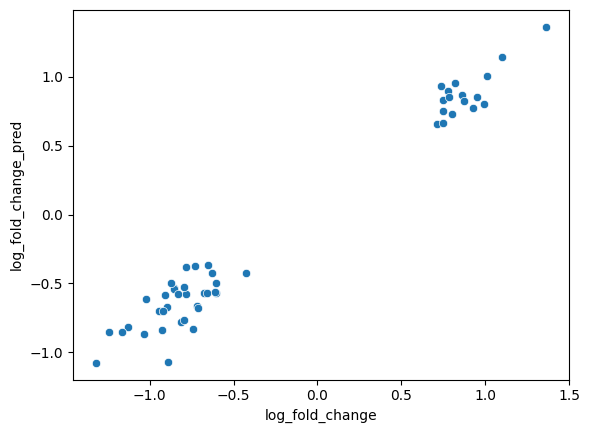

In [49]:
import seaborn as sns

sns.scatterplot(logfc_df_deg, x="log_fold_change", y="log_fold_change_pred")

In [50]:
r2_score(logfc_df_deg["log_fold_change"].values, logfc_df_deg["log_fold_change_pred"].values)

0.9409177628185319

In [53]:
logfc_df.sort_values("log_fold_change")

gene  log_fold_change  log_fold_change_pred
621      COL26A1        -1.323103             -1.077601
924       INSIG1        -1.241413             -0.854494
1645  AC010197.1        -1.162751             -0.857352
1245   CEACAM22P        -1.129716             -0.820236
163        DHRS2        -1.034470             -0.868585
...          ...              ...                   ...
396         KRT7         0.948886              0.856566
269         KYNU         0.990460              0.805947
214        ABCC3         1.012518              1.003864
37         ABCC2         1.102265              1.143102
988      AKR1B10         1.366019              1.364408

[2000 rows x 3 columns]

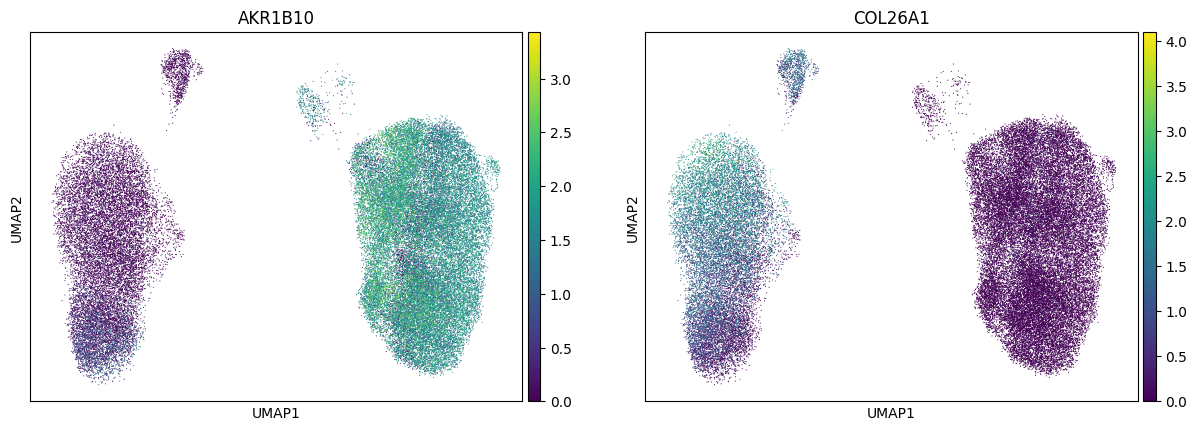

In [55]:
sc.pl.umap(adata_train, color=["AKR1B10", "COL26A1"])